<img src="http://www.kitquant.com/kqimages/logo_card_cropped.png" alt="Drawing" style="width: 180px;" align="center"/><center>

# Sentiment Analysis for financial data tutorial in Python

This tutorial aims to present different NLP (Natural Language Processing) techniques:
- **Sentiment Analysis** : Exctracting the sentiment from the text (is a news positive or negative, etc..).
- **Preprocessing** : The data always needs to be preprocessed in order to be able to extract relevant information.
- **Label Propagation** : Completing the sentiment analysis model using label propagation.
- **Classificaiton models** : How do we build a Machine Learning model using text as features.

### Importing the libraries

In [1]:
import pandas as pd
# NLP library for preprocessing
import nltk
# Progression bar
from tqdm import tqdm
import os
import datetime
import matplotlib.pyplot as plt
import seaborn

### Importing and cleaning the data

**Twitter data :**

In [2]:
path_twitter = "twitter_data/"
l_files = os.listdir(path_twitter)

Some files are not well written and could not be parsed easily with pandas, we will ignore them.

In [3]:
# Reading all files and concatening them
l_datas = []

for f_read in tqdm(l_files):
    try:
        data_tmp = pd.read_csv(path_twitter + f_read, compression='gzip', header=None, engine="python",
                               names=["Symbol", "Id", "Date_raw", "Author", "Hashtag", "Tweet"])
        l_datas.append(data_tmp)
    except Exception as e:
        # one could prind the exception with print(e) or apply a special treatment
        pass

data_twitter = pd.concat(l_datas)

100%|██████████| 13948/13948 [00:31<00:00, 437.56it/s]


In [4]:
print("The proportion of files kept is {0:0.1%}".format(len(l_datas) / float(len(l_files))))

The proportion of files kept is 95.8%


We will convert the date to two columns (Date and seconds from midnight) in order to reduce the storage and keep the same format as the stock data (integers require less space to store).

In [5]:
def extract_time(date_raw):
    try:
        date = datetime.datetime.strptime(date_raw.replace(" +0000", ""), '%a %b %d %H:%M:%S %Y')
        return int((date - date.replace(hour=0, minute=0, second=0)).total_seconds())
    except:
        return
        
def extract_date(date_raw):
    try:
        date = datetime.datetime.strptime(date_raw.replace(" +0000", ""), '%a %b %d %H:%M:%S %Y').date()
        date = int(date.strftime("%Y%m%d"))
        return date
    except :
        return

In [6]:
data_twitter["Time"] = data_twitter["Date_raw"].apply(extract_time)
data_twitter["Date"] = data_twitter["Date_raw"].apply(extract_date)

We discard the author and the hashtag in this analysis. One could after add a relevance score per author.

In [7]:
col_keep = ["Symbol", "Date", "Time", "Tweet"]

In [8]:
data_twitter = data_twitter[col_keep]
print(len(data_twitter))
data_twitter = data_twitter.dropna()
print(len(data_twitter))

820130
819632


In [9]:
data_twitter.head()

,Symbol,Date,Time,Tweet
0,MRK,20180105.0,85256.0,Investors Buy Shares of Merck &amp; Co. Inc. $...
1,MRK,20180105.0,84269.0,#dcvax-l new better safe low-side-effects $fb ...
2,MRK,20180105.0,84105.0,$MRK high OI range is 55.00 to 56.00 for optio...
3,MRK,20180105.0,82936.0,$OPGN #beastmode afterhours; news coming Monda...
4,MRK,20180105.0,82236.0,Notable greedy companies who aren’t giving the...


**Stock data:**

In [10]:
data_stocks = pd.read_csv("stocks.csv", header=None,
                          names=["Symbol", "Date", "Time", "Open", "High", "Low", "Close", "Volume"])

We convert the date to an integer:

In [11]:
data_stocks["Date"] = data_stocks["Date"].apply(lambda x: int(x.replace("-", "")))

In [12]:
data_stocks["Time"] = data_stocks["Time"].apply(lambda x: int(x[:2]) * 60**2 + int(x[3:5]) * 60 + int(x[6:8]))

In [13]:
data_stocks.head()

,Symbol,Date,Time,Open,High,Low,Close,Volume
0,A,20171227,34200,67.21,67.32,67.16,67.32,10726
1,A,20171227,34260,67.32,67.34,67.32,67.34,500
2,A,20171227,34320,67.28,67.28,67.23,67.23,400
3,A,20171227,34380,67.23,67.23,67.16,67.22,800
4,A,20171227,34500,67.23,67.26,67.23,67.26,600


In [14]:
def compute_returns_date_stock(data, l_returns, price="Open"):
    data = data.copy()
    for ret in l_returns:
        data["FuturReturn_{}".format(ret)] = data[price].pct_change(periods=-ret) * 10**4
        data["PastReturn_{}".format(ret)] = data[price].pct_change(periods=ret) * 10**4
    return data

def compute_returns_stock(data_stock, l_returns, price="Open"):
    dates = data_stock.Date.unique()

    l_datas_out = []
    for date in dates:
        data = data_stock[data_stock["Date"] == date]
        l_datas_out.append(compute_returns_date_stock(data, l_returns, price))

    return pd.concat(l_datas_out)

def compute_returns(data_stocks, l_returns, price="Open"):
    stocks = data_stocks.Symbol.unique()

    l_datas_out = []
    for stock in tqdm(stocks):
        data_stock = data_stocks[data_stocks["Symbol"] == stock]
        l_datas_out.append(compute_returns_stock(data_stock, l_returns, price))

    data_out = pd.concat(l_datas_out)
    data_out.dropna(inplace=True)

    return data_out

These operations could be parallelized over a grid of computers or on the different processors of the computer.

In [15]:
returns = [5, 10, 15, 30, 60]

In [16]:
data_stocks = compute_returns(data_stocks, returns)

100%|██████████| 633/633 [16:02<00:00,  1.52s/it]


** Merging the data **

In [17]:
data_twitter = data_twitter.sort_values(["Date", "Symbol", "Time"])
data_stocks = data_stocks.sort_values(["Date", "Symbol", "Time"])

In [18]:
data_twitter['Time'] = data_twitter['Time'].astype(int)

In [19]:
ret_past = [col for col in data_stocks.columns if "PastReturn" in col]
ret_fut = [col for col in data_stocks.columns if "FuturReturn" in col]

In [20]:
def merge_stock_date(data_twitter_stock_date, data_stock_date):
    cols_common = ["Symbol", "Date", "Time"]
    # global variables
    cols_past = cols_common + ret_past
    cols_fut = cols_common + ret_fut

    # Dealing with past and futur return differently
    data_all_fut = pd.merge_asof(data_twitter_stock_date, data_stock_date[cols_fut],
                                 suffixes=("", "_2"), on="Time", direction="forward")
    data_all_past = pd.merge_asof(data_twitter_stock_date, data_stock_date[cols_past], 
                                  suffixes=("", "_2"), on="Time", direction="backward")

    data_all_fut.dropna(inplace=True)
    data_all_past.dropna(inplace=True)

    data_all_fut = data_all_fut[cols_common + ["Tweet"] + ret_fut]
    data_all_past = data_all_past[cols_common + ["Tweet"] + ret_past]

    data_all = data_all_fut.merge(data_all_past, on="Time", suffixes=('', '_y'))

    return data_all[cols_common + ["Tweet"] + ret_past + ret_fut]

def merge_stock(data_twitter_stock, data_stock):
    dates = data_twitter_stock.Date.unique()
    l_datas_out_stock = []

    for date in dates:
        data_twitter_date_stock = data_twitter_stock[data_twitter_stock["Date"] == date]
        data_stock_date = data_stock[data_stock["Date"] == date]
        l_datas_out_stock.append(merge_stock_date(data_twitter_date_stock, data_stock_date))

    return pd.concat(l_datas_out_stock)

In [21]:
stocks = data_twitter.Symbol.unique()

In [22]:
l_datas_out_all = []

for stock in tqdm(stocks):
    data_twitter_stock = data_twitter[data_twitter["Symbol"] == stock]
    data_stock = data_stocks[data_stocks["Symbol"] == stock]
    l_datas_out_all.append(merge_stock(data_twitter_stock, data_stock))

100%|██████████| 534/534 [40:47<00:00,  4.58s/it]


In [23]:
data = pd.concat(l_datas_out_all)

In [24]:
data.to_csv("data.csv", index=False)

In [25]:
data.head()

,Symbol,Date,Time,Tweet,PastReturn_5,PastReturn_10,PastReturn_15,PastReturn_30,PastReturn_60,FuturReturn_5,FuturReturn_10,FuturReturn_15,FuturReturn_30,FuturReturn_60
0,A,20171227.0,38425,Dimensional Fund Advisors LP Decreases Positio...,0.741895,-7.412898,7.423905,5.938242,11.883541,1.483900,0.000000,7.423905,2.968240,13.370970
1,A,20171227.0,38685,✅Binance ❌Poloniex ❌Bittrex Move your trading...,-14.836795,-11.872959,-20.759193,-8.907363,-4.455666,-1.483680,4.453682,1.484120,1.484120,5.939124
2,A,20171227.0,40390,$SWAY $A $BEE $AT $A $BEE $IM $RAD,4.453682,1.484120,4.453682,-1.483680,2.968680,1.484120,8.911332,7.425007,10.398099,11.885307
3,A,20171227.0,42075,Sivik Global Healthcare Increased Agilent Tech...,-1.485001,-2.969562,-5.937361,-1.648325,-7.420600,0.000000,0.000000,-7.420600,1.485443,-4.453682
4,A,20171227.0,42689,Unknown - Commercial Break $A LISTEN LIVE HERE...,0.000000,-1.485001,-1.485001,-7.420600,1.485443,-1.485001,7.431629,5.944420,-1.485001,1.485443


# Sentiment Analysis

In order to extract the sentiment of the tweet, we will count the number of positive words (good, well, profit ..) and negative words (bad, decrease ..) in the tweet. 

The score for each tweet will be : number_+_words - number_-_words.

The model takes as input a list of positive words and a list of negative words (that could be found online or in the folder).

In [26]:
class Analyzer():
    """Implements sentiment analysis."""

    def __init__(self, positives, negatives):
        """Initialize Analyzer."""
        text_positive = open(positives, "r")
        positives_not_clean = text_positive.read().split(";")[-1].split("\n")
        # Cleaning the data
        self.positives = [word for word in positives_not_clean if word != ""]
        
        text_negative = open(negatives, "r")
        negatives_not_clean = text_negative.read().split(";")[-1].split("\n")
        # Cleaning the data
        self.negatives = [word for word in negatives_not_clean if word != ""]

        

    def analyze(self, text):
        """Analyze text for sentiment, returning its score."""

        text = text.lower()
        score = 0
        for word in self.positives:
            word = word.lower()
            if word in text:
                score += 1

        for word in self.negatives:
            word = word.lower()
            if word in text:
                score -= 1    
        return score

In [27]:
analyzer = Analyzer("positive-words.txt", "negative-words.txt")

In [28]:
data["Score"] = data["Tweet"].apply(analyzer.analyze)

We will study the correlation between the non-null scores and the returns.

In [29]:
data_study = data[data["Score"] != 0]

We will plot the future return 15 minutes against the score:

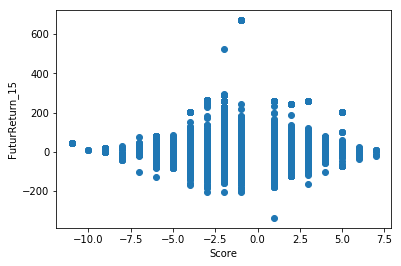

In [30]:
plt.figure()
plt.plot(data_study["Score"], data_study["FuturReturn_15"], "o")
plt.xlabel("Score")
plt.ylabel("FuturReturn_15")
plt.show()

For better visualisation, we will group the scores:

In [31]:
def group_scores(score):
    if score < -5:
        return -3
    elif score < -2:
        return -2
    elif score < 0:
        return -1
    elif score < 2:
        return 1
    elif score < 5:
        return 2
    else:
        return 3

In [32]:
data_study["Score_group"] = data_study["Score"].apply(group_scores)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


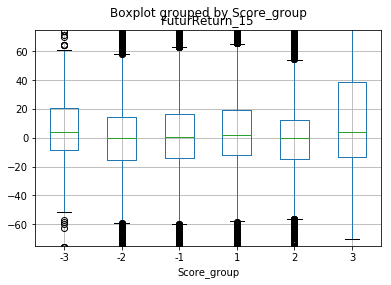

In [33]:
data_study.boxplot(by="Score_group", column="FuturReturn_15")
plt.ylim(-75, 75)
plt.show()

The past retrun 15 minutes:

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


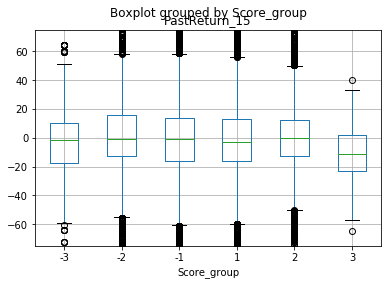

In [34]:
data_study.boxplot(by="Score_group", column="PastReturn_15")
plt.ylim(-75, 75)
plt.show()

** Correlation according to the returns **

In [35]:
data_corr = data_study.corr()

In [36]:
returns = [5, 10, 15, 30, 60]
corrs_past = [data_corr.loc["Score", "PastReturn_{}".format(ret)] for ret in returns[::-1]]
corrs_fut = [data_corr.loc["Score", "FuturReturn_{}".format(ret)] for ret in returns]

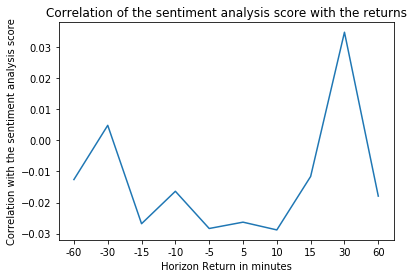

In [37]:
plt.figure()
corrs = corrs_past + corrs_fut
plt.plot(range(len(corrs)), corrs)
plt.xticks(range(len(corrs)), [-ret for ret in returns[::-1]] + returns)
plt.xlabel("Horizon Return in minutes")
plt.ylabel("Correlation with the sentiment analysis score")
plt.title("Correlation of the sentiment analysis score with the returns")
plt.show()

The correlation are not very stable as there is a lot of noise.

# Preprocessing - Word2vec

## Preprocessing

Before building an NLP model, one needs to preprocess the data. We will go through the different steps of preprocessing:
- Removing the punctuation.
- Removing the stop words (general words such as a, an, and, the ..) as they occur very often and don't add a lot of values.
- Stemming the words ie extracting the root (having => have, has => have).

**Lower the text**

In [38]:
data['Tweet'] = data['Tweet'].apply(lambda x: x.lower())
data.iloc[:,:4].head(3)

,Symbol,Date,Time,Tweet
0,A,20171227.0,38425,dimensional fund advisors lp decreases positio...
1,A,20171227.0,38685,✅binance ❌poloniex ❌bittrex move your trading...
2,A,20171227.0,40390,$sway $a $bee $at $a $bee $im $rad


** Removing the punctuation **

In [39]:
import string
data['Tweet'] = data['Tweet'].apply(lambda x: x.translate(string.punctuation))
data.iloc[:,:4].head(3)

,Symbol,Date,Time,Tweet
0,A,20171227.0,38425,dimensional fund advisors lp decreases positio...
1,A,20171227.0,38685,✅binance ❌poloniex ❌bittrex move your trading...
2,A,20171227.0,40390,$sway $a $bee $at $a $bee $im $rad


**Removing the emojis**

Here we clean the emojis as the word2vec model does not support them, however if one has a personalized word2vec model one can keep them as they contain information.

In [40]:
#data['Tweet'] = data['Tweet'].apply(lambda x: filter(lambda y: y in string.printable, x))
data.iloc[:,:4].head(3)

,Symbol,Date,Time,Tweet
0,A,20171227.0,38425,dimensional fund advisors lp decreases positio...
1,A,20171227.0,38685,✅binance ❌poloniex ❌bittrex move your trading...
2,A,20171227.0,40390,$sway $a $bee $at $a $bee $im $rad


** Removing the stopwords **

Use nltk.download() in an ipython console to download the corpus stopwords.

In [41]:
# extracting the stopwords from nltk library
sw = nltk.corpus.stopwords.words('english')

In [42]:
print(sw)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [43]:
def remove_stopwords(text):
    '''a function for removing the stopword'''
    # removing the stop words and lowercasing the selected words
    text = [word.lower() for word in text.split(' ') if word.lower() not in sw]
    # joining the list of words with space separator
    return " ".join(text)

In [44]:
data['Tweet'] = data['Tweet'].apply(remove_stopwords)
data.iloc[:,:4].head(3)

,Symbol,Date,Time,Tweet
0,A,20171227.0,38425,dimensional fund advisors lp decreases positio...
1,A,20171227.0,38685,✅binance ❌poloniex ❌bittrex move trading #1 c...
2,A,20171227.0,40390,$sway $a $bee $at $a $bee $im $rad


** Stemming **

In [45]:
# create an object of stemming function
stemmer = nltk.stem.SnowballStemmer("english")

def stemming(text):    
    '''a function which stems each word in the given text'''
    text = [stemmer.stem(word) for word in text.split()]
    return " ".join(text) 

In [46]:
data['Tweet'] = data['Tweet'].apply(stemming)
data.iloc[:,:4].head(3)

,Symbol,Date,Time,Tweet
0,A,20171227.0,38425,dimension fund advisor lp decreas posit agil t...
1,A,20171227.0,38685,✅binanc ❌poloniex ❌bittrex move trade #1 crypt...
2,A,20171227.0,40390,$sway $a $bee $at $a $bee $im $rad


## Word2Vec

Word2vec is a model that learns a representation of words. It uses underneath the wood, neural networks that learns an embedding allowing them to predict the next word using the context (https://www.tensorflow.org/tutorials/word2vec).

Here, we will use a pretrained word2vec model on google news data that you can download <a href="https://www.tensorflow.org/tutorials/word2vec">here</a>.

In [48]:
import gensim

In [50]:
# Load Google's pre-trained Word2Vec model.
model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)  

Getting the most similar words from the model:

In [51]:
model.most_similar("stock")

[('shares', 0.7760442495346069),
 ('stocks', 0.6025432348251343),
 ('Shares', 0.5807890892028809),
 ('Stock', 0.5690754055976868),
 ('stockmarket', 0.54961097240448),
 ('market_capitalization', 0.5441644191741943),
 ('VNDA', 0.5439260005950928),
 ('Autozone_NYSE_AZO', 0.5406639575958252),
 ('Insider_buying', 0.5401883125305176),
 ('shareprice', 0.5363472700119019)]

We can visualize the model using a t-SNE which is a method for dimension reduction:

In [52]:
from sklearn.manifold import TSNE

100%|██████████| 100/100 [00:00<00:00, 22753.09it/s]


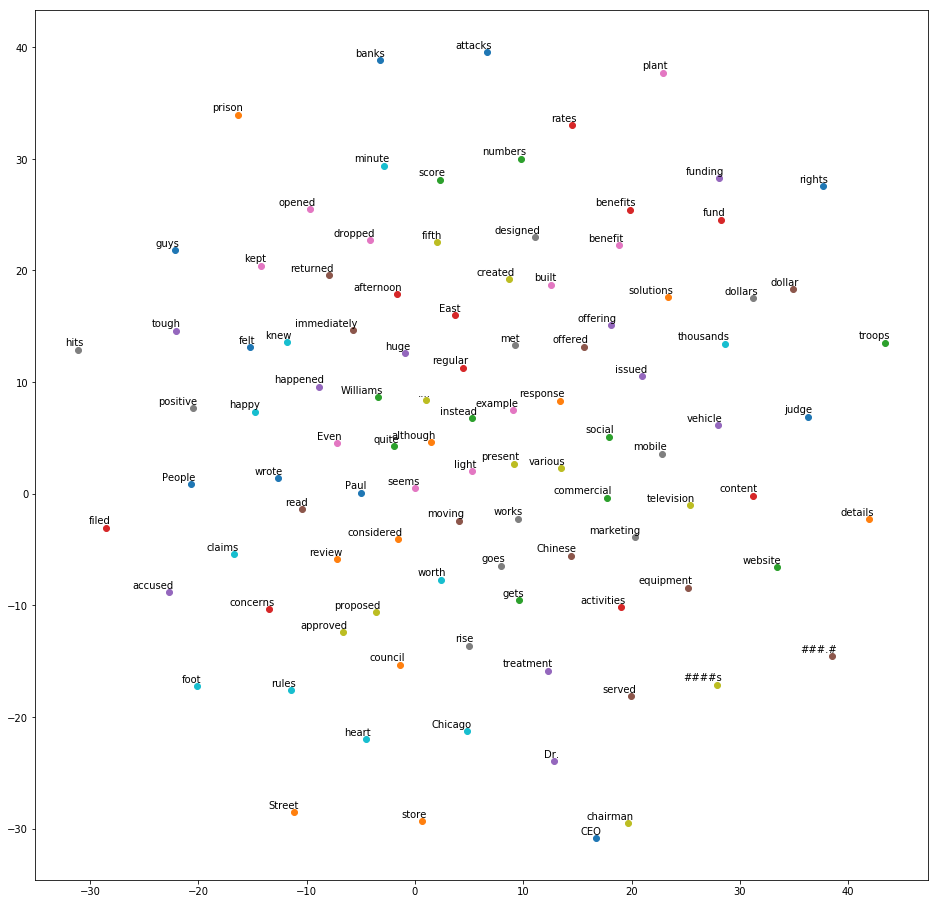

In [53]:
def tsne_plot(model, nb_words, threshold=1000):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    # Counts of words
    counts = []

    for word in model.vocab:
        counts.append(model.vocab[word].count)

    max_count = max(counts)

    sorted_words = [word for count,word in sorted(zip(counts, model.vocab), reverse=True)
                    if count < (threshold * max_count)][threshold:(threshold + nb_words)]

    for word in tqdm(sorted_words):
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16))

    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

tsne_plot(model, 100)

The t-SNE model is a powerfull source of visualisation, on this graph the closest two words are and the more associated they are, for instance "present" and "happy" are pretty close.

In [54]:
import numpy as np

def construct_embedding(text):
    words = text.split(" ")
    embeddings = []

    for word in words:
        try:
            embeddings.append(model.word_vec(word))
        except:
            pass

    n_words = len(embeddings)

    if n_words != 0:
        mean_embeddings = sum(embeddings) / float(n_words)
        return mean_embeddings
    else:
        return  np.zeros(300)

In [55]:
data["Embedding"] = data["Tweet"].apply(construct_embedding)

Filtering the lines with only words that are not in the model:

In [56]:
data["Filter"] = data["Embedding"].apply(lambda x: x.sum())

In [57]:
print("Percentage of lines kept: {0:.2%}".format(len(data[data["Filter"] != 0]) / float(len(data))))

Percentage of lines kept: 94.75%


In [58]:
data = data[data["Filter"] != 0]

In [59]:
data[['feat{}'.format(i) for i in range(1, 301)]] = pd.DataFrame(data["Embedding"].apply(list).values.tolist(), index= data.index)

In [60]:
data.head(3)

,Symbol,Date,Time,Tweet,PastReturn_5,PastReturn_10,PastReturn_15,PastReturn_30,PastReturn_60,FuturReturn_5,...,feat291,feat292,feat293,feat294,feat295,feat296,feat297,feat298,feat299,feat300
0,A,20171227.0,38425,dimension fund advisor lp decreas posit agil t...,0.741895,-7.412898,7.423905,5.938242,11.883541,1.48390,...,-0.071228,0.032397,-0.093750,0.022339,-0.040798,-0.213797,0.025539,-0.012418,-0.074402,0.090890
1,A,20171227.0,38685,✅binanc ❌poloniex ❌bittrex move trade #1 crypt...,-14.836795,-11.872959,-20.759193,-8.907363,-4.455666,-1.48368,...,0.152832,0.063538,-0.031362,-0.010132,0.091447,-0.016780,0.041911,-0.042236,0.027252,0.055819
3,A,20171227.0,42075,sivik global healthcar increas agil technolog ...,-1.485001,-2.969562,-5.937361,-1.648325,-7.420600,0.00000,...,0.044769,0.047424,-0.021233,0.078476,0.008492,-0.049630,-0.048454,0.088051,-0.048645,0.024250


In [61]:
X = data[['feat{}'.format(i) for i in range(1, 301)]]
y_label = data["Score"]
y = data["FuturReturn_15"]

In [62]:
X.head()

,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,feat9,feat10,...,feat291,feat292,feat293,feat294,feat295,feat296,feat297,feat298,feat299,feat300
0,0.004658,0.016253,-0.006627,0.035579,-0.030849,0.076869,0.092564,-0.180734,0.073493,-0.058838,...,-0.071228,0.032397,-0.093750,0.022339,-0.040798,-0.213797,0.025539,-0.012418,-0.074402,0.090890
1,-0.021505,0.029867,-0.037109,0.095479,0.031576,0.100260,-0.071472,-0.008565,0.091878,0.057210,...,0.152832,0.063538,-0.031362,-0.010132,0.091447,-0.016780,0.041911,-0.042236,0.027252,0.055819
3,-0.070360,0.039215,-0.088531,0.063980,-0.066299,-0.051727,0.037460,-0.110718,0.121664,0.024929,...,0.044769,0.047424,-0.021233,0.078476,0.008492,-0.049630,-0.048454,0.088051,-0.048645,0.024250
4,0.066803,0.018417,-0.029083,0.041809,-0.095886,0.088816,0.058350,-0.008759,0.167572,0.154915,...,0.010620,0.076477,-0.116211,0.011658,-0.088745,-0.102295,-0.086205,-0.059326,0.091675,-0.078690
5,0.066803,0.018417,-0.029083,0.041809,-0.095886,0.088816,0.058350,-0.008759,0.167572,0.154915,...,0.010620,0.076477,-0.116211,0.011658,-0.088745,-0.102295,-0.086205,-0.059326,0.091675,-0.078690


# Label Propagation

Here we use label propagation algorithm, which is a graph based algorithm that generates labels for the data. (http://scikit-learn.org/stable/modules/label_propagation.html)

Here, we will propagate the labels using the highest sentiment score.

In [63]:
y_label_train = np.zeros_like(y_label)
thresh = 2
X_1 = X[y_label > thresh]
X_2 = X[y_label < -thresh]
n_1 = len(X_1)
n_2 = len(X_2)
n_3 = min(n_1, n_2)

y_label_train[y_label > thresh] = 2
y_label_train[y_label < -thresh] = 0
y_label_train[(y_label >= -thresh) & (y_label <= thresh)] = 1

# We put -1 for the set of unlabeled data
counts = {0 : 0, 1 : 0, 2 : 0}
for i in range(len(y_label_train)):
    elem = y_label_train[i]
    counts[elem] += 1

    if counts[elem] > n_3:
        y_label_train[i] = -1

In [64]:
from sklearn.semi_supervised import label_propagation

We will use a PCA in order to reduce the dimension as the matrix is too large:

In [65]:
n_components = 10

In [66]:
from sklearn.decomposition import PCA
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X)

In [67]:
label_proba = label_propagation.LabelPropagation(n_jobs=-1, kernel="knn")

In [68]:
label_proba.fit(X_pca, y_label_train)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=1000 was reached without convergence.
  category=ConvergenceWarning


LabelPropagation(alpha=None, gamma=20, kernel='knn', max_iter=1000, n_jobs=-1,
         n_neighbors=7, tol=0.001)

In [69]:
y_new_labels = label_proba.transduction_

In [70]:
data_result = data[[col for col in data.columns if "Return" in col]].copy()
data_result["Score"] = y_new_labels

In [71]:
data_corr = data_result.corr()

In [72]:
corrs_past = [data_corr.loc["Score", "PastReturn_{}".format(ret)] for ret in returns[::-1]]
corrs_fut = [data_corr.loc["Score", "FuturReturn_{}".format(ret)] for ret in returns]

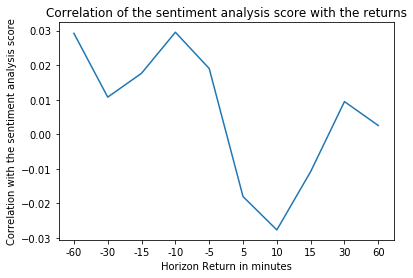

In [73]:
plt.figure()
corrs = corrs_past + corrs_fut
plt.plot(range(len(corrs)), corrs)
plt.xticks(range(len(corrs)), [-ret for ret in returns[::-1]] + returns)
plt.xlabel("Horizon Return in minutes")
plt.ylabel("Correlation with the sentiment analysis score")
plt.title("Correlation of the sentiment analysis score with the returns")
plt.show()

We observe that the negative returns are correlated with the sentiment analysis score. In fact, an explanation could be that the news was spread on finance media (such as Bloomberg) and that traders used this information to trade and thus impacting the market. After that, the news reached with a delay the social media and people started to tweet against the stock.

# Deep Learning model for classification

Creating three classes:
- High positive returns
- Low returns (that don't cover for transaction fees)
- High negative returns

In [74]:
n = len(X)

In [75]:
def group_return(x):
    if x < -2:
        return -1
    elif x < 2:
        return 0
    else:
        return 1

In [76]:
y_ret = y.apply(group_return)

In [78]:
X_train = X.iloc[:int(n/2)]
y_train = y_ret.iloc[:int(n/2)]

X_test = X.iloc[int(n/2):]
y_test = y_ret.iloc[int(n/2):]

In [80]:
from keras.models import Sequential
from keras.layers import Dense, Activation

Using TensorFlow backend.
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [81]:
# Converting the data to the right format
from keras.utils import to_categorical
y_test = to_categorical(y_test, num_classes=3)
y_train = to_categorical(y_train, num_classes=3)

Here, we use a deep neural network with 2 layers:

In [82]:
model_nn = Sequential()
model_nn.add(Dense(32, activation='relu', input_dim=300))
model_nn.add(Dense(3, activation='sigmoid'))
model_nn.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model_nn.fit(X_train, y_train, epochs=10, batch_size=32, verbose=2)

Epoch 1/10
 - 8s - loss: 0.8781 - acc: 0.5290
Epoch 2/10
 - 7s - loss: 0.8350 - acc: 0.5701
Epoch 3/10
 - 7s - loss: 0.8148 - acc: 0.5860
Epoch 4/10
 - 8s - loss: 0.8013 - acc: 0.5941
Epoch 5/10
 - 7s - loss: 0.7913 - acc: 0.6011
Epoch 6/10
 - 7s - loss: 0.7827 - acc: 0.6066
Epoch 7/10
 - 7s - loss: 0.7762 - acc: 0.6103
Epoch 8/10
 - 7s - loss: 0.7699 - acc: 0.6129
Epoch 9/10
 - 7s - loss: 0.7652 - acc: 0.6163
Epoch 10/10
 - 7s - loss: 0.7604 - acc: 0.6192


In [83]:
y_pred = model_nn.predict(X_test)

In [84]:
y_pred = y_pred.argmax(axis=1).reshape(-1,)

In [85]:
y_test = y_test.argmax(axis=1).reshape(-1,)

In [86]:
accuracy = np.sum(y_pred == y_test)/ float(len(y_test))

In [87]:
print("The accuracy of the model is equal to {0:.2%}".format(accuracy))

The accuracy of the model is equal to 48.02%


The accuracy is not always the best way to measure the performance (especially when the classes are imbalanced), we can plot the confusion matrix:

In [88]:
from sklearn.metrics import confusion_matrix

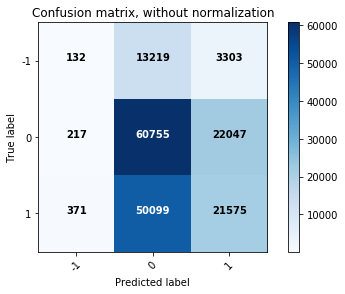

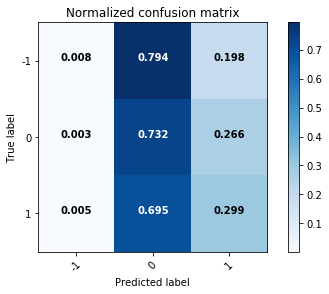

In [89]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    from matplotlib.font_manager import FontProperties
    font0 = FontProperties()
    font = font0.copy()
    font.set_weight('bold')


    fmt = '.3f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",
                 fontproperties=font)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=3)
class_names = [-1, 0, 1]

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

The model seems to perform badly for predicting the 15 minutes return.
One may try to predict a more long-term return (1-2 days) as the tweets are delayed and the intraday traders get the information quicker (as we saw in the correlation graph with the sentiment analysis score).

Also, mutliple improvements could be explored:
- Include regularization techniques (dropout etc..).
- Use convolution and more complex structures to account for the complexity of the data (http://www.aclweb.org/anthology/D14-1181).
- Use more evolved techniques in order to summarize the information in the data and deleting the noise (event detection for instance : https://fenix.tecnico.ulisboa.pt/downloadFile/1689244997255675/Resumo%20Alargado%20-%20MEE%20-%2066020%20-%20Mariana%20-%20Daniel.pdf).
- Retrain the word2vec on financial data (bloomberg..), so it would be more specialized in the domain.

&copy; 2018 Kitquant LLC.